In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import os
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
data_dir = './kaggle/input'
df_train = pd.read_csv(os.path.join(data_dir, 'train.csv'))
df_test = pd.read_csv(os.path.join(data_dir, 'test.csv'))

### Question 1
Do we need 4 independent models for 4 interesting features or is there some relationship between them? Lets quickly do pairwise plot to see. (Even before really reading into the feature descriptions)

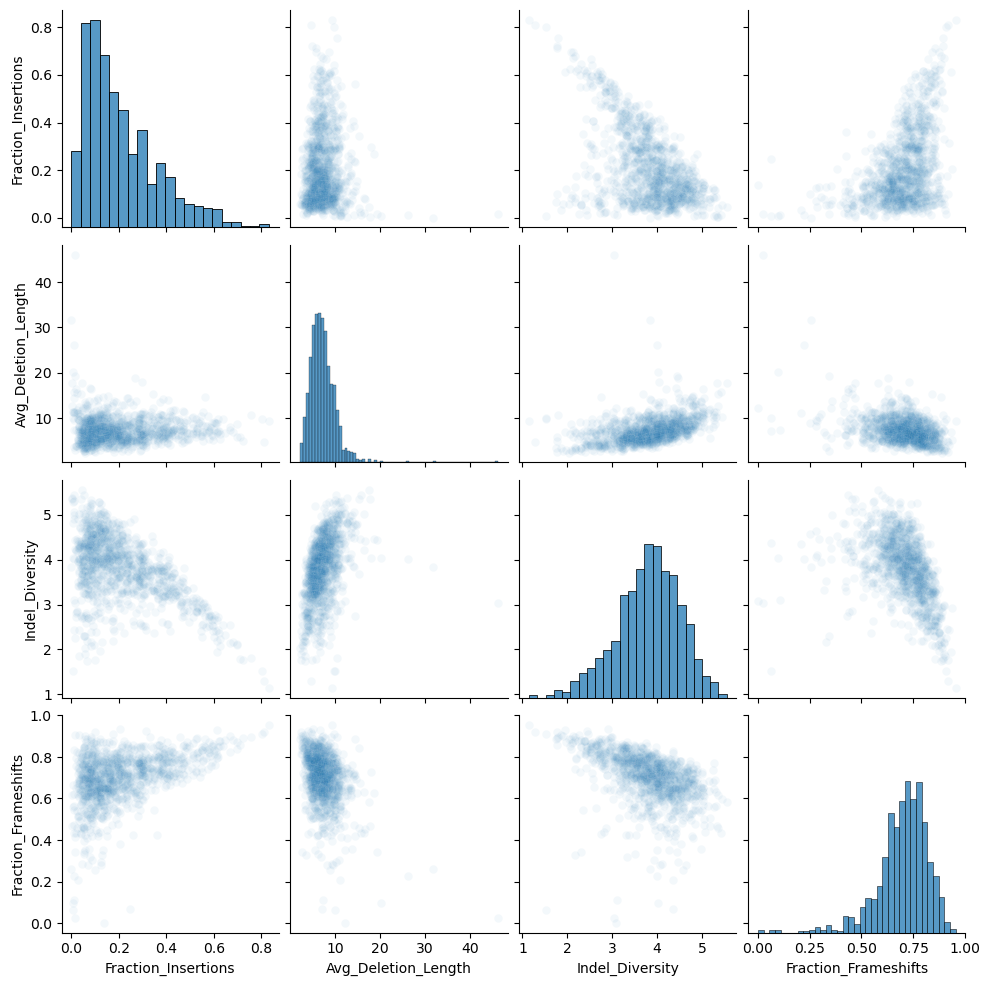

In [15]:
sns.pairplot(df_train.drop(columns=['GuideSeq', 'Id']), plot_kws={'alpha': 0.05})

### Question 2
All 4 features seem like aggregates of the data. Let's see how the were obtained in the paper (simultaneouly trying to not see their results :) ).

> This study involved 3,989 DNA repair profiles from T cells isolated from 18 individuals. These outcomes targeted 1,521 unique sites within 549 genes in the human genome.

From this we conclude that each individual dataset sample was aggregated from on average 3 "original data" samples, hence its predictive power may not be that high. There is no STD in the dataset, however the "Indel_diversity" is defined as follows:
> We use the entropy of the distribution of the reads over the indel types as a metric to quantify the diversity of the repair outcomes. If there is exactly one repair outcome in all of the reads, then the entropy is 0. Higher entropy means that the repair outcomes are more diverse.

which means that it can be used as a metric of how reliable prediction can be made for each individual sequence.

### Superficial observation 1
We have a lot more training datapoint than features that we will predict (none of predicted features are sequences, so no "expansion" foreseen), this is great, decreases our chances of overfitting.
There are no NAs and all the sequences of the same length, which is also great.


### Idea 1
It seems plausible that the outcomes are related to combinations of letters, so we should probably add synthetic columns. Quick estimation of what can reasonably fit in memory/cpu time. We have order 1000 rows, which means we will have 1kb/feature (as pandas allocates 1 byte/boolean + up to 500 bytes per column). Without columns overhead taken into account, one-hot encoding of single letters will generate 20*len('AGCT')*1kb = 80 kb. For 2 letters: 19 * len('AGCT')^2 * 1kb = 304kb, For 3 letters: 18 * len('AGCT')^3 = 1_152 kb, etc

| letters used | memory usage (kb) |
| -------- | ------- |
|  1 | 80    |
|  2 | 304 |
|  3 | 1_152 |
|  4 | 4_352 |
|  5 | 16_384 |
|  6 | 61_140 |
|  7 | 229_376 |
|  8 | 851_968 |
|  9 | 3_145_728 |
|  10 | 11_534_336 |

With columns overhead on top, memory footprint should roughly 1.5-2x higher. (since we have ~1000 bytes for data and around ~500 bytes for column overhead). Hence it seems that one-hot encoding of 6-8 base pairs is reasonable.



In [8]:
seq_len = df_train['GuideSeq'].apply(len)
seq_len.describe()

count    1065.0
mean       23.0
std         0.0
min        23.0
25%        23.0
50%        23.0
75%        23.0
max        23.0
Name: GuideSeq, dtype: float64